In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import time

from sklearn.model_selection import train_test_split

import os
if not os.path.isdir('proj_figures'):
    os.makedirs('proj_figures')

In [2]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [3]:
# scaler for data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [4]:
NUM_CLASSES = 3

epochs = 250
batch_sizes = [4, 8, 16, 32, 64]
#batch_size = 32
num_neurons = 10
seed = 10

num_attributes = 21

np.random.seed(seed)
tf.random.set_seed(seed)

histories={}

In [5]:
dataset = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
X, Y = dataset[1:,:21], dataset[1:,-1].astype(int)
Y = Y - 1 #For python that start from 0

#Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed, shuffle=True)

#Scale based on training set 
X_test = scale(X_test,np.min(X_train,axis = 0),np.max(X_train, axis=0))
X_train = scale(X_train, np.min(X_train, axis = 0),np.max(X_train, axis = 0 ))

In [6]:
#Model definition
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, activation = 'relu',input_dim = num_attributes,kernel_regularizer=keras.regularizers.l2(1e-6)))
    model.add(keras.layers.Dense(NUM_CLASSES, activation ='softmax'))

    #default of sgd is lr = 0.01 so no need specify
    model.compile(optimizer='sgd',
                 loss = keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    
    return model

In [7]:
#Define callback to csv logger
time_callback = TimeHistory()
callbacks = [time_callback]

In [8]:
#Train models for 250 epochs and takes average time over 250 epochs as the time per epoch
for batch_size in batch_sizes:
    model = build_model()
    model.fit(X_train, Y_train,validation_data=(X_test,Y_test),
                                            epochs=epochs,
                                            verbose = 2,
                                            batch_size=batch_size,
                                            callbacks=callbacks)
    ave_1_epoch = sum(time_callback.times)/epochs
    histories[batch_size]=ave_1_epoch

Epoch 1/250
372/372 - 0s - loss: 0.7019 - accuracy: 0.7675 - val_loss: 0.6390 - val_accuracy: 0.7790
Epoch 2/250
372/372 - 0s - loss: 0.6221 - accuracy: 0.7782 - val_loss: 0.5877 - val_accuracy: 0.7790
Epoch 3/250
372/372 - 0s - loss: 0.5745 - accuracy: 0.7789 - val_loss: 0.5424 - val_accuracy: 0.7837
Epoch 4/250
372/372 - 0s - loss: 0.5307 - accuracy: 0.7843 - val_loss: 0.4950 - val_accuracy: 0.7931
Epoch 5/250
372/372 - 0s - loss: 0.4909 - accuracy: 0.8044 - val_loss: 0.4565 - val_accuracy: 0.8088
Epoch 6/250
372/372 - 0s - loss: 0.4534 - accuracy: 0.8192 - val_loss: 0.4277 - val_accuracy: 0.8213
Epoch 7/250
372/372 - 0s - loss: 0.4241 - accuracy: 0.8273 - val_loss: 0.4007 - val_accuracy: 0.8542
Epoch 8/250
372/372 - 0s - loss: 0.4004 - accuracy: 0.8380 - val_loss: 0.3746 - val_accuracy: 0.8574
Epoch 9/250
372/372 - 0s - loss: 0.3793 - accuracy: 0.8441 - val_loss: 0.3594 - val_accuracy: 0.8589
Epoch 10/250
372/372 - 0s - loss: 0.3622 - accuracy: 0.8562 - val_loss: 0.3510 - val_accura

In [9]:
histories.values()

dict_values([0.29736191940307616, 0.2123088836669922, 0.12757038116455077, 0.07231375789642334, 0.04842441082000733])

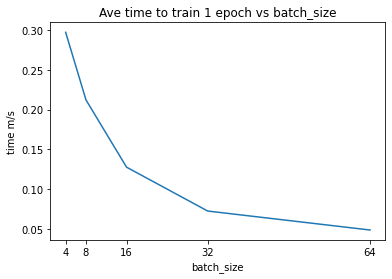

In [10]:
plt.plot(histories.keys(),histories.values())
plt.xticks(batch_sizes)
plt.title('Ave time to train 1 epoch vs batch_size')
plt.ylabel('time m/s')
plt.xlabel('batch_size')
plt.savefig('./figures/2A_batch_size_vs_time_per_epoch.png')
plt.show()